# GRB analysis

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 

#### Python tip. Web request and smarter file reading

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

In [3]:

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [4]:
print(data)

[['GRB230606A' 'GRB230603A*' 'GRB230529A*' ... 'GRB910424A*'
  'GRB910423A*' 'GRB910421A*']
 ['GRB230606010' 'GRB230603525' 'GRB230529330' ... 'None' 'None' 'None']
 ['0:14:37' '12:35:28.934' '7:54:43.268' ... '19:43:25.064'
  '19:51:15.804' '9:14:03.800']
 ...
 ['16.2380' '20.4800' '36.6080' ... '3.1360' '208.5760' '5.6960']
 ['False' 'True' 'True' ... 'False' 'False' 'False']
 ['60101.01015046' '60098.52464044' '60093.32966745' ... '48370.82181787'
  '48369.82726625' '48367.38476620']]


# Analysis

### 1D analysis

Let's look into the distribution of the GRBs time to try to divide the short GRBs to the long ones, as the name suggests we expect to divide the time dataset into two clusters

In [5]:
grb=dict(zip(names,data))

for lab in ['T90','redshift','T90_error', 'fluence']:
    grb[lab] = np.array(grb[lab],dtype=float)

In [6]:
grb.keys()

dict_keys(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error', 'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error', 'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'])

In [7]:
# log of the time
lT90 = np.log10(grb['T90'])
# removing nans
lT90=lT90[~np.isnan(lT90)]

/tmp/ipykernel_77696/3336075466.py:2: RuntimeWarning: invalid value encountered in log10
  lT90 = np.log10(grb['T90'])


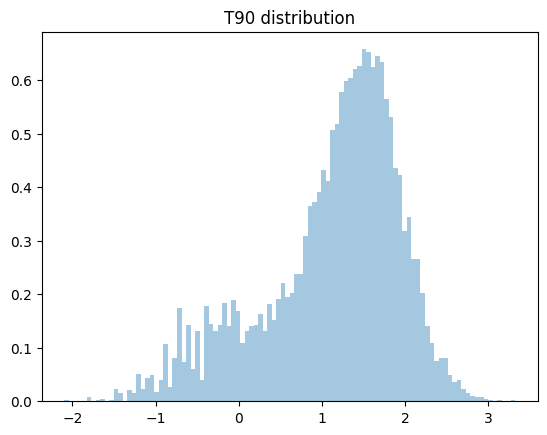

In [8]:
plt.hist(lT90, bins = 100, density=True, alpha = .4)
plt.title('T90 distribution');

In order to reduce bias due to sampling we'll use kernel density to represent our data

In [9]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(lT90[:, None]) #fit the model to the data

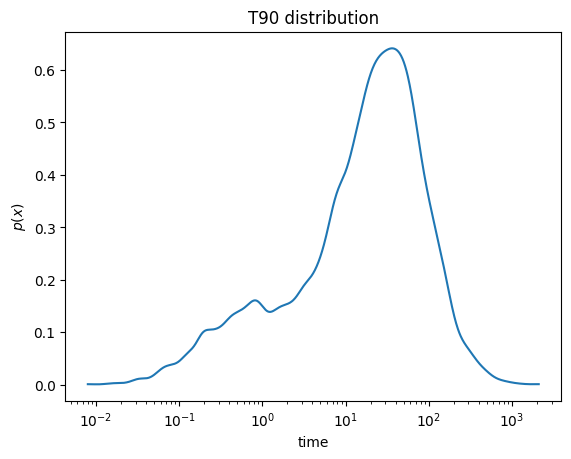

In [10]:
xgrid=np.logspace(min(lT90),max(lT90),1000)
# Rememember score_samples is the log-likelihood. Neep an exp in front
ygrid = np.exp(kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

plt.plot(xgrid,ygrid)
plt.semilogx()

plt.title('T90 distribution')
plt.ylabel(r'$p(x)$')
plt.xlabel('time');

Now let's classify them using clustering techiniques

## Kmeans

In [11]:
from sklearn.cluster import KMeans

X = lT90[:, None] #sklearn vector 
n = 2   #number of clusters

km = KMeans(n, n_init=10) #it's the default value, i set n_init to suppress the warning
km.fit(X)

KMeans(n_clusters=2, n_init=10)

It happened to me that the labels have flipped, to ensure which is which i'm gonna order them

In [12]:
labels = km.predict(np.log10(xgrid)[:, None]) #the fit is in log!
mask = labels==1

In [13]:
if (xgrid[mask] > 10**(2)).any():
    labels[mask] = 0
    labels[~mask] = 1

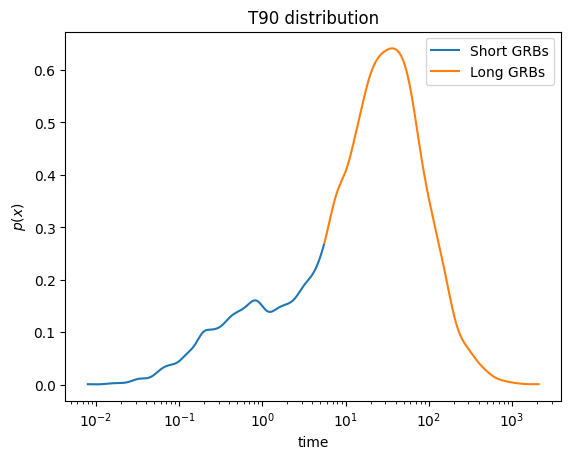

In [14]:
mask = labels==1 #updating the mask now

plt.plot(xgrid[mask], ygrid[mask], label='Short GRBs')
plt.plot(xgrid[~mask], ygrid[~mask], label='Long GRBs')

plt.semilogx()

plt.title('T90 distribution')
plt.ylabel(r'$p(x)$')
plt.xlabel('time')
plt.legend();

Now let's understand the clusters boundaries, we need the centers and the edges

In [15]:
centers = 10**km.cluster_centers_ # remember that the fit is in log scale
print('The time in seconds at which the two clusters are centered are: %.2f' % centers[0],
      'and %.2f' % centers[1])

The time in seconds at which the two clusters are centered are: 33.64 and 0.91


Now the edge of my two clusters will be defined by the average between the last point of one cluster and the first of the new one

In [16]:
mask = labels==1 #updating the mask

In [17]:
print(max(xgrid[mask]))
print(min(xgrid[~mask]))

5.497074927292568
5.566166721555946


In [18]:
edge = (max(xgrid[mask]) + min(xgrid[~mask]))/2
print(edge)

5.531620824424257


The two clusters are centered at: 33.64 and 0.91 seconds
They are divided at: 5.53 seconds


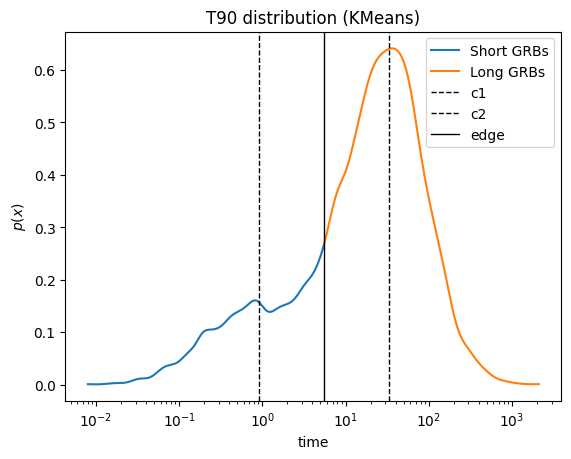

In [19]:
plt.plot(xgrid[mask], ygrid[mask], label='Short GRBs')
plt.plot(xgrid[~mask], ygrid[~mask], label='Long GRBs')

## adding clusters positions
plt.axvline(centers[0], 0, 1, ls='--', lw=1 ,c='k', label = 'c1')
plt.axvline(centers[1], 0, 1, ls='--', lw=1 ,c='k', label = 'c2')

plt.axvline(edge, 0, 1, c='k', lw=1, label = 'edge')

plt.semilogx()

plt.title('T90 distribution (KMeans)')
plt.ylabel(r'$p(x)$')
plt.xlabel('time')
plt.legend()

print('The two clusters are centered at: %.2f' %centers[0], 'and %.2f' %centers[1], 'seconds')
print('They are divided at: %.2f' %edge, 'seconds')

### Elbow plot

It uses SSE (a.k.a. Cluster Inertia) to evaluate the goodness of split. SSE is a measure of the variance inside your cluster. Then we create an elbow plot of SSE for K values ranging from 2 to N (you can set the value of N for your research). As K increases, the corresponding SSE will decrease. We’ll observe the trade-off between K and SSE (we want the SSE to be low while keeping K at a reasonable value)

In [61]:
nrange = np.arange(2,10)

kms = []

for i,n in enumerate(nrange):
    kms.append(KMeans(n_clusters=n, n_init=10))
    kms[i].fit(X)

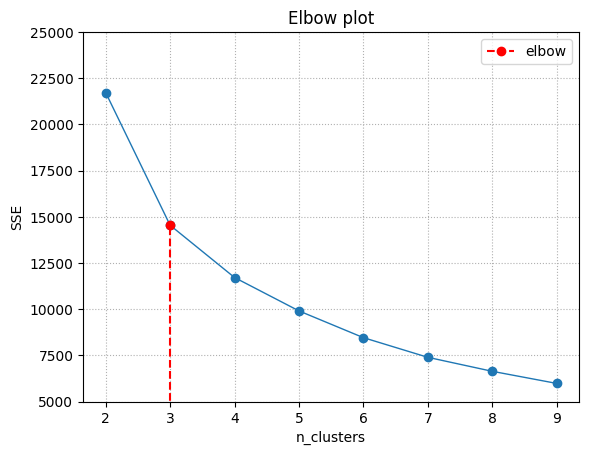

In [116]:
scores = [km.inertia_ for km in kms]
plt.plot(nrange, scores, '-o', lw=1)
plt.plot([3,3],[0,scores[1]], '--or', label = 'elbow')

plt.ylim(5e3, 2.5e4)
plt.title('Elbow plot')
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.grid(ls='dotted')
plt.legend();

Elbow suggests somewhere around 3 clusters as the best fit

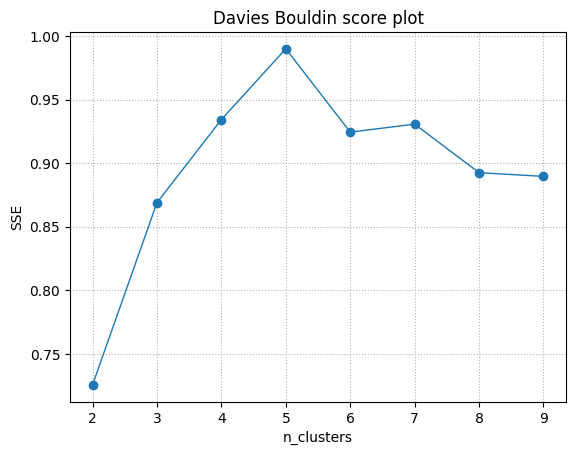

In [119]:
from sklearn.metrics import davies_bouldin_score as db

dbs = [db(X, km.labels_) for km in kms]

plt.plot(nrange, dbs, '-o', lw=1)

plt.title('Davies Bouldin score plot')
plt.xlabel('n_clusters')
plt.ylabel('db_score')
plt.grid(ls='dotted');

The smaller the Davies-Bouldin Index, the farther away these clusters are, the better the clustering is. So this suggests 2 is the best value

---

### CV error
Let's check wether two is the actual number of clusters preferred by the algorithm, **turns out that using CV for an unsupervised process is not a smart idea** the reason has to do with how cv works, basically it tries to minimize your scoring method, which is interpeted as a loss function. In the case of Kmeans the scoring method appears to be given to each point has the distance between that point and the centroid of your class, this causes your code to converge to 0 (which will be the minimum distance) for N clusters where N is the number of points.

In [21]:
from sklearn.model_selection import GridSearchCV

nrange = [2,3,4,5,6,7,8,9,10]
K = 4 #4-fold cross validation
n_i = 10*np.ones(len(nrange))
n_i = n_i.astype(int)

In [22]:
grid = GridSearchCV(KMeans(), {'n_clusters': nrange, 'n_init': n_i}, cv= K) 
#i had to set the n_init in order to suppress the waring, 10 is the default value

In [23]:
grid.fit(X)

GridSearchCV(cv=4, estimator=KMeans(),
             param_grid={'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_init': array([10, 10, 10, 10, 10, 10, 10, 10, 10])})

In [24]:
h_opt = grid.best_params_['n_clusters']
print(h_opt)

10


In [25]:
labels_cv = grid.predict(np.log10(xgrid[:, None]))

In [26]:
masks = [labels_cv == i for i in np.arange(0,max(nrange))]

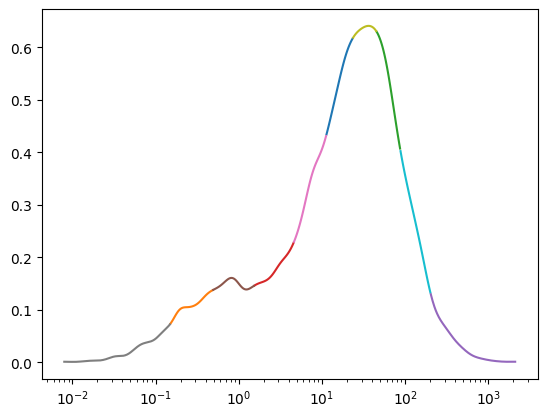

In [27]:
for mask in masks:
    plt.plot(xgrid[mask], ygrid[mask])
    
plt.semilogx();

In [28]:
test_scores = grid.cv_results_['mean_test_score']
print(test_scores)

[-378.2212081  -378.14951899 -378.54903637 -378.79564659 -378.64432239
 -378.14951899 -378.77755053 -378.14951899 -378.14951899 -185.60902874
 -185.91371332 -185.87964431 -185.90786543 -185.63731079 -185.9210004
 -185.84490189 -185.79579147 -185.81976035 -117.19304628 -117.07225642
 -117.79088239 -117.09279981 -117.07636642 -117.43043195 -117.34104362
 -117.13702327 -117.19993515  -79.83098107  -80.73371203  -79.67824178
  -80.10089018  -80.1047365   -79.91083142  -79.48217136  -80.37084238
  -80.37063236  -56.68844612  -57.48338259  -57.87332692  -57.22348198
  -56.84746312  -56.55923727  -56.92513308  -57.21576675  -56.69934983
  -42.66638472  -42.5005286   -42.62752707  -42.4967258   -42.57523001
  -42.36255594  -42.28377427  -42.4363493   -42.51862552  -33.67745415
  -34.04628234  -33.90284238  -33.66785801  -33.96586445  -34.00428548
  -33.77059891  -34.05096629  -33.86311223  -27.38599142  -28.53005668
  -28.75893958  -27.92835067  -28.5597819   -28.50114168  -28.33268889
  -28.9

---

## Mean shift

In [29]:
from sklearn.cluster import MeanShift, estimate_bandwidth

X = lT90[:, None] #sklearn vector

print(estimate_bandwidth(X))

0.5200961660392468


This estimation is wrong because it predicts only one cluster, i set the bandwith by eye to have 2 clusters

In [30]:
bs = 0.4
ms = MeanShift(bandwidth=bs) #bandwith automatically estimated
ms.fit(X)

MeanShift(bandwidth=0.4)

In [31]:
labels = ms.predict(np.log10(xgrid)[:,None])
cluster_centers = ms.cluster_centers_ #the fit was in log!
cluster_centers = 10**cluster_centers

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 2


In [32]:
mask = labels==1 #updating the mask

The two clusters are centered at: 31.99 and 0.94 seconds
They are divided at: 5.53 seconds


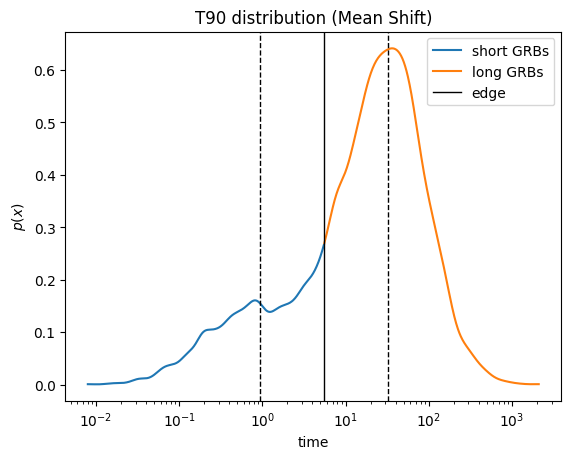

In [33]:
plt.plot(xgrid[mask], ygrid[mask], label='short GRBs')
plt.plot(xgrid[~mask], ygrid[~mask], label='long GRBs')
plt.axvline(cluster_centers[0], lw=1, ls='--', c='k')
plt.axvline(cluster_centers[1], lw=1, ls='--', c='k')

edge = (max(xgrid[mask]) + min(xgrid[~mask]))/2
plt.axvline(edge, lw=1, c='k', label = 'edge')


plt.semilogx();


plt.title('T90 distribution (Mean Shift)')
plt.ylabel(r'$p(x)$')
plt.xlabel('time')

print('The two clusters are centered at: %.2f' %cluster_centers[0], 'and %.2f' %cluster_centers[1], 'seconds')
print('They are divided at: %.2f' %edge, 'seconds')

plt.legend();

In [34]:
print('The two methods estimate the following centers:')
print('KMeans: %.2f' %centers[0], 'and %.2f' %centers[1], 'seconds')
print('Meanshift: %.2f' %cluster_centers[0], 'and %.2f' %cluster_centers[1], 'seconds')

The two methods estimate the following centers:
KMeans: 33.64 and 0.91 seconds
Meanshift: 31.99 and 0.94 seconds


### Scoring

In [137]:
bandwiths = np.linspace(.1,1,5)

mss = []

for i,b in tqdm(enumerate(bandwiths)):
    mss.append(MeanShift(bandwidth=b))
    mss[i].fit(X)

0it [00:00, ?it/s]

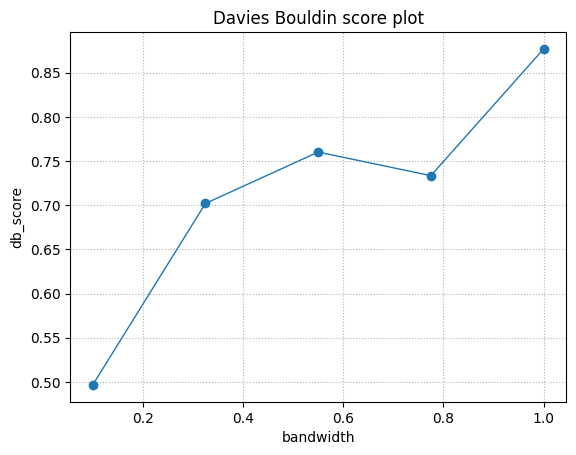

In [138]:
from sklearn.metrics import davies_bouldin_score as db

dbs = [db(X, ms.labels_) for ms in mss]

plt.plot(bandwiths, dbs, '-o', lw=1)

plt.title('Davies Bouldin score plot')
plt.xlabel('bandwidth')
plt.ylabel('db_score')
plt.grid(ls='dotted');

kmeans seems to suggest a bandwith value between 0 (unreasonable) and 0.2, this would correspond to a very high number of clusters and this would not really make sense. We'll take our .4 

---

### Does it make sense to use 3 clusters instead of 2?
You could compute the BIC to show if there's evidence for the 3rd cluster, instead of doing it for kmeans we will use gaussian mixture since it's already implemented and we're not too far off from the dataset

In [176]:
from sklearn.mixture import GaussianMixture

gms = [GaussianMixture(n_components=2), GaussianMixture(n_components=3)]

X = lT90[:, None]

for gm in gms:
    gm.fit(X)

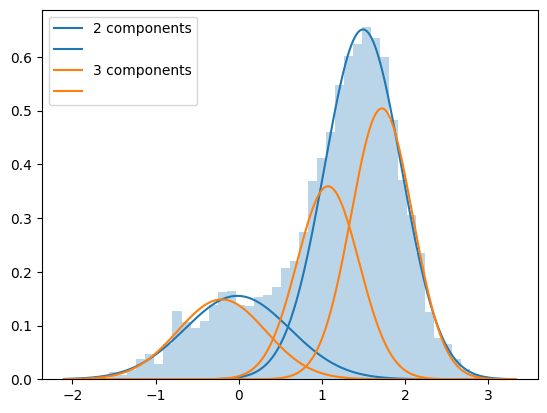

In [213]:
plt.hist(X, bins = 50, alpha = .3, density = True)

xgrid = np.linspace(min(X), max(X), 1000)

for i,gm in enumerate(gms):
    resps = gm.predict_proba(xgrid)
    pdf = np.exp(gm.score_samples(xgrid))[:, None]
    plt.plot(xgrid, resps*pdf, c=cm(i));

plt.legend(['2 components', None, '3 components', None]);

Now let's compute the AIC/BIC

In [228]:
AICs = [gm.aic(xgrid) for gm in gms]
BICs = [gm.bic(xgrid) for gm in gms]

print('AIC results for 2 and 3 components:', AICs)
print('BIC results for 2 and 3 components:', BICs)

AIC results for 2 and 3 components: [5595.494810729146, 5986.149497074743]
BIC results for 2 and 3 components: [5620.033587124057, 6025.4115393065995]


Seems like two clusters is justified

If you want to do it with kmeans you need to implement the BIC yourself using something of this kind

In [139]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)